# `OOD Detection applied to SST2 and IMDB`


In [1]:

import pandas as pd 
import numpy as np 

from tqdm import tqdm
import datasets
from datasets import load_dataset

import pandas as pd 
import numpy as np 

from tqdm import tqdm
from typing import List, Dict


from itertools import chain

import matplotlib.pyplot as plt 
from matplotlib.axes import Axes
import seaborn as sns

import pickle as pkl 
import json

from sklearn.metrics import (
    roc_curve, 
    precision_recall_curve, 
    auc
) 


from transformers import AutoConfig, BertForSequenceClassification

import torch 
from torch import Tensor


from Todd import (
    ScorerType, 
    MahalanobisScorer, 
    CosineProjectionScorer, 
    DataDepthScorer, 
)


from toddbenchmark.classification_datasets import (
    prep_model, 
    load_sst2, 
)
from toddbenchmark.classification_datasets_configs import (
    DATASETS_CONFIGS,
    load_requested_dataset,
)

from toddbenchmark.utils_classification import (
    prepare_detectors,
    evaluate_dataloader,
)


from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

#
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, minmax_scale, MinMaxScaler

#metrics 
from sklearn.metrics import accuracy_score ,balanced_accuracy_score, make_scorer, confusion_matrix, f1_score, classification_report, roc_auc_score


from Todd import (
    ScorerType, 
    MahalanobisScorer, 
    CosineProjectionScorer, 
    DataDepthScorer, 
)

# `Our models`

This work is based on Bert architectures. 

In [2]:
Models = {"BERT": "echarlaix/bert-base-uncased-sst2-acc91.1-d37-hybrid", "DistilBERT": "distilbert-base-uncased-finetuned-sst-2-english"} 

model, tokenizer = prep_model(Models["BERT"], config={"label": 2})

In [3]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=320, bias=True)
              (key): Linear(in_features=768, out_features=320, bias=True)
              (value): Linear(in_features=768, out_features=320, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=320, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### **`Datasets`**

**In-DS : SST2**

In [4]:
config_args_sst2 = { "tokenizer": tokenizer, "train_size": 1000, "validation_size": 000, "test_size": 1000, "ood_label" : 0}

train_loader_sst2, val_loader_sst2, test_loader_sst2 = load_requested_dataset(config_name="sst2", **config_args_sst2)


Found cached dataset glue (/Users/joevincentgaltie/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

**Out-DS : IMDB**

In [5]:
config_args_imdb = { "tokenizer": tokenizer, "train_size": 0, "validation_size": 0, "test_size": 1000, "ood_label" : 1}


_, _, test_loader_imdb = load_requested_dataset(config_name="imdb", **config_args_imdb)

Found cached dataset imdb (/Users/joevincentgaltie/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [62]:
next(iter(test_loader_imdb))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

{'text': ['I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as

In [63]:
sum(batch["labels"].shape[0] for batch in test_loader_imdb)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

3000

 **very OOD dataset**

In [6]:
config_args_imdb = { "tokenizer": tokenizer, "train_size": 0, "validation_size": 0, "test_size": 1000, "ood_label" : 1}


_, _, test_loader_rte = load_requested_dataset(config_name="rte", **config_args_imdb)

Found cached dataset glue (/Users/joevincentgaltie/.cache/huggingface/datasets/glue/rte/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [64]:
print(next(iter(train_loader_sst2)))
print("")
print(next(iter(test_loader_imdb)))
print("")
print(next(iter(test_loader_rte)))
print("")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

-------
-------

### `Very simplistic supervised approach`

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = BertForSequenceClassification.from_pretrained("echarlaix/bert-base-uncased-sst2-acc91.1-d37-hybrid", num_labels=2,output_hidden_states = True)
model.to(device)

mean_embeddings = torch.zeros(1,768)

with torch.no_grad():
    for batch in tqdm(train_loader_sst2):

        inputs = tokenizer(batch['text'], return_tensors="pt", truncation=True, padding=True)['input_ids'].to(device)
        outputs = model(inputs)

        
        hidden_states = outputs.hidden_states

        for i in range(13):
                embedding_batch=[]
                layer_embeddings = hidden_states[i][:, 0, :]  #First_token
                embedding_batch.append(layer_embeddings)
                
        embedding_batch_mean= torch.mean(torch.stack(embedding_batch,dim=0),dim=0)   # 

        if mean_embeddings.size() ==(1,768) : 
            mean_embeddings = embedding_batch_mean
        else : 
            mean_embeddings = torch.cat((mean_embeddings, embedding_batch_mean), dim=0)


100%|██████████| 188/188 [01:33<00:00,  2.02it/s]


In [7]:
hidden_in = hidden_states

In [8]:
hidden_in

(tensor([[[ 1.5597e-01, -2.6601e-01, -3.1719e-01,  ..., -4.8019e-03,
            1.4476e-02,  1.5220e-01],
          [ 5.4636e-01,  5.7812e-01,  1.5213e-01,  ...,  4.5618e-01,
            4.5436e-01,  3.2401e-01],
          [ 9.5170e-02,  2.9671e-01, -3.9846e-01,  ..., -7.3581e-01,
           -7.8258e-01, -1.5708e+00],
          ...,
          [ 5.6678e-02, -3.4025e-01,  8.7591e-02,  ...,  1.2868e-04,
           -3.9694e-01, -7.2258e-02],
          [ 6.4300e-02, -3.0502e-01,  2.5136e-01,  ...,  6.6114e-02,
           -4.7288e-01, -4.5710e-02],
          [ 3.5985e-02, -4.2692e-01,  7.2300e-02,  ..., -1.7924e-02,
           -4.7128e-01, -7.0074e-02]],
 
         [[ 1.5597e-01, -2.6601e-01, -3.1719e-01,  ..., -4.8019e-03,
            1.4476e-02,  1.5220e-01],
          [ 1.5144e+00, -4.4829e-01,  3.0224e-01,  ...,  2.9192e-01,
            1.2440e+00, -9.3474e-01],
          [ 1.0959e+00,  3.2115e-01, -5.1600e-01,  ...,  7.1904e-01,
            3.0999e-01,  6.4771e-01],
          ...,
    

In [9]:
mean_embeddings_in_ds = mean_embeddings


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = BertForSequenceClassification.from_pretrained("echarlaix/bert-base-uncased-sst2-acc91.1-d37-hybrid", num_labels=2,output_hidden_states = True)
# model.to(device)

mean_embeddings = torch.zeros(1,768)

with torch.no_grad():
    for batch in tqdm(test_loader_imdb):
        inputs = tokenizer(batch['text'], return_tensors="pt", truncation=True, padding=True)['input_ids'].to(device)
        outputs = model(inputs)

        
        hidden_states = outputs.hidden_states

        for i in range(13):
                embedding_batch=[]
                layer_embeddings = hidden_states[i][:, 0, :]
                embedding_batch.append(layer_embeddings)
                
        embedding_batch_mean= torch.mean(torch.stack(embedding_batch,dim=0),dim=0)

        if mean_embeddings.size() ==(1,768) : 
            mean_embeddings = embedding_batch_mean
        else : 
            mean_embeddings = torch.cat((mean_embeddings, embedding_batch_mean), dim=0)

  0%|          | 0/188 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 188/188 [17:32<00:00,  5.60s/it]


In [11]:
mean_embeddings_out_ds = mean_embeddings

In [12]:
hidden_out = hidden_states

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = BertForSequenceClassification.from_pretrained("echarlaix/bert-base-uncased-sst2-acc91.1-d37-hybrid", num_labels=2,output_hidden_states = True)
# model.to(device)

mean_embeddings = torch.zeros(1,768)

with torch.no_grad():
    for batch in tqdm(test_loader_rte):
        inputs = tokenizer(batch['text'], return_tensors="pt", truncation=True, padding=True)['input_ids'].to(device)
        outputs = model(inputs)

        
        hidden_states = outputs.hidden_states

        for i in range(13):
                embedding_batch=[]
                layer_embeddings = hidden_states[i][:, 0, :]
                embedding_batch.append(layer_embeddings)
                
        embedding_batch_mean= torch.mean(torch.stack(embedding_batch,dim=0),dim=0)

        if mean_embeddings.size() ==(1,768) : 
            mean_embeddings = embedding_batch_mean
        else : 
            mean_embeddings = torch.cat((mean_embeddings, embedding_batch_mean), dim=0)

mean_embeddings_very_out_ds = mean_embeddings

  0%|          | 0/188 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 188/188 [03:49<00:00,  1.22s/it]


In [16]:
hidden_very_out = hidden_states

In [22]:
mean_embeddings_out_ds.mean(axis=0).mean(axis=-1)
mean_embeddings_in_ds.mean(axis=0).mean(axis=-1)

tensor(-0.0083)

In [24]:
mean_embeddings_in_ds.size()

torch.Size([3000, 768])

In [17]:
tensor0 = mean_embeddings_in_ds
tensor1 = mean_embeddings_out_ds
data = np.hstack((tensor0, np.zeros((tensor0.shape[0], 1))))
data = np.vstack((data, np.hstack((tensor1, np.ones((tensor1.shape[0], 1))))))


In [19]:
data.shape

(6000, 769)

In [26]:
#data[:,:-1]
data[:,-1]

array([0., 0., 0., ..., 1., 1., 1.])

In [18]:
x_train,x_test,y_train,y_test=train_test_split(data[:,:-1],data[:,-1],test_size=0.2,shuffle=True)

In [18]:
x_train

array([[-0.55904216, -0.43559647, -0.0313114 , ...,  0.49893102,
         0.09465267, -0.39085919],
       [-0.34506315,  0.04499663,  0.09334722, ...,  0.63350242,
         0.13094577, -0.26817828],
       [-0.20789309,  0.10821149, -0.20289591, ...,  0.03219894,
        -0.03383854, -0.05451637],
       ...,
       [-0.20111321,  0.04926404, -0.12717004, ...,  0.14218518,
         0.08264235, -0.27493972],
       [-0.44319183, -0.42821157,  0.08542095, ...,  0.16278829,
         0.13088672, -0.45157534],
       [-0.46162727, -0.37721238, -0.02091554, ...,  0.23836938,
         0.1703843 , -0.45602089]])

In [24]:
len(x_test)

400

In [67]:
import collections
collections.Counter(y_test)

Counter({1.0: 573, 0.0: 627})

In [21]:
pipe = Pipeline([('XGB', XGBClassifier())])
parameters = { 'XGB__max_depth':[1,2,3,4],
               'XGB__n_estimators':[200,300,400,500]     
               #'RF__class_weight':['balanced', 'balanced_subsample'],
               #'RF__min_samples_split':range(2,10),
               #'RF__min_samples_leaf':range(1,5)
              } # defining parameter space
xgb_clf = GridSearchCV(pipe, parameters, cv=4, scoring ='f1')
xgb_clf.fit(x_train, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('XGB',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constraints=N...
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'XGB__max_depth': [1, 2, 3, 4],
                         'XGB__n_estimators': [200, 300, 400, 500]},
             scoring='f1')

In [33]:
y_test

array([1., 0., 0., ..., 1., 0., 1.])

In [23]:
xgb_clf.predict(x_test)

array([1, 0, 1, ..., 0, 1, 1])

In [24]:
print('Returned hyperparameter: {}'.format(xgb_clf.best_params_))
print('Best classification accuracy in train is: {}'.format(xgb_clf.best_score_))
print('Classification accuracy on test is: {}'.format(f1_score(xgb_clf.predict(x_test),y_test)))

Returned hyperparameter: {'XGB__max_depth': 1, 'XGB__n_estimators': 200}
Best classification accuracy in train is: 0.9995836802664446
Classification accuracy on test is: 1.0


In [25]:
print(xgb_clf.best_params_)

print(f1_score(xgb_clf.predict(x_test),y_test))

print(confusion_matrix(xgb_clf.predict(x_test),y_test))

print(classification_report(xgb_clf.predict(x_test),y_test))

{'XGB__max_depth': 1, 'XGB__n_estimators': 200}
1.0
[[603   0]
 [  0 597]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       603
           1       1.00      1.00      1.00       597

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



In [26]:
x_test[:,135]

array([ 0.23581612, -0.25889003,  0.45506257, ..., -0.27125096,
        0.27422741,  0.23673633])

In [27]:
print(np.argwhere(xgb_clf.best_estimator_[0].feature_importances_>0))
xgb_clf.best_estimator_[0].feature_importances_[np.argwhere(xgb_clf.best_estimator_[0].feature_importances_>0)]


[[ 26]
 [135]
 [225]
 [270]
 [327]
 [372]
 [447]
 [473]
 [481]
 [483]
 [710]]


array([[0.01510642],
       [0.59271187],
       [0.12673469],
       [0.01469333],
       [0.00111662],
       [0.01038871],
       [0.06692992],
       [0.14920813],
       [0.01863094],
       [0.00255041],
       [0.00192892]], dtype=float32)

In [28]:
tensor0 = mean_embeddings_in_ds
tensor1 = mean_embeddings_very_out_ds
data = np.hstack((tensor0, np.zeros((tensor0.shape[0], 1))))
data = np.vstack((data, np.hstack((tensor1, np.ones((tensor1.shape[0], 1))))))

x_train,x_test,y_train,y_test=train_test_split(data[:,:-1],data[:,-1],test_size=0.2,shuffle=True)


pipe = Pipeline([('XGB', XGBClassifier())])
parameters = { 'XGB__max_depth':[1,2,3,4],
               'XGB__n_estimators':[200,300,400,500]     
               #'RF__class_weight':['balanced', 'balanced_subsample'],
               #'RF__min_samples_split':range(2,10),
               #'RF__min_samples_leaf':range(1,5)
              } # defining parameter space
xgb2_clf = GridSearchCV(pipe, parameters, cv=4, scoring ='f1')
xgb2_clf.fit(x_train, y_train)


print('Returned hyperparameter: {}'.format(xgb2_clf.best_params_))
print('Best classification accuracy in train is: {}'.format(xgb2_clf.best_score_))
print('Classification accuracy on test is: {}'.format(f1_score(xgb2_clf.predict(x_test),y_test)))

Returned hyperparameter: {'XGB__max_depth': 1, 'XGB__n_estimators': 400}
Best classification accuracy in train is: 0.9950508414814049
Classification accuracy on test is: 0.9947826086956523


In [29]:
print(xgb2_clf.best_params_)

print(f1_score(xgb2_clf.predict(x_test),y_test))

print(confusion_matrix(xgb2_clf.predict(x_test),y_test))

print(classification_report(xgb2_clf.predict(x_test),y_test))

{'XGB__max_depth': 1, 'XGB__n_estimators': 400}
0.9947826086956523
[[622   1]
 [  5 572]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       623
           1       1.00      0.99      0.99       577

    accuracy                           0.99      1200
   macro avg       1.00      0.99      0.99      1200
weighted avg       1.00      0.99      0.99      1200



In [30]:
print(np.argwhere(xgb2_clf.best_estimator_[0].feature_importances_>0))
xgb2_clf.best_estimator_[0].feature_importances_[np.argwhere(xgb2_clf.best_estimator_[0].feature_importances_>0)]

[[ 20]
 [ 25]
 [ 52]
 [ 59]
 [ 63]
 [ 65]
 [ 78]
 [ 79]
 [ 84]
 [101]
 [102]
 [110]
 [133]
 [135]
 [144]
 [145]
 [170]
 [174]
 [188]
 [191]
 [200]
 [211]
 [220]
 [223]
 [232]
 [243]
 [244]
 [254]
 [259]
 [261]
 [271]
 [273]
 [301]
 [311]
 [318]
 [321]
 [324]
 [326]
 [355]
 [356]
 [368]
 [370]
 [372]
 [396]
 [402]
 [406]
 [418]
 [421]
 [422]
 [423]
 [425]
 [432]
 [435]
 [437]
 [447]
 [453]
 [458]
 [474]
 [478]
 [481]
 [483]
 [484]
 [489]
 [490]
 [492]
 [498]
 [502]
 [519]
 [521]
 [524]
 [538]
 [550]
 [558]
 [563]
 [564]
 [565]
 [571]
 [576]
 [600]
 [604]
 [606]
 [611]
 [613]
 [617]
 [621]
 [626]
 [633]
 [649]
 [654]
 [656]
 [658]
 [665]
 [672]
 [688]
 [694]
 [699]
 [704]
 [706]
 [709]
 [716]
 [721]
 [729]
 [732]
 [736]
 [740]
 [755]
 [758]
 [763]
 [766]]


array([[2.01289295e-04],
       [1.67538601e-05],
       [3.51903960e-04],
       [4.42179822e-04],
       [1.24058244e-03],
       [2.98577407e-03],
       [8.88011942e-04],
       [9.15906765e-03],
       [1.29157546e-04],
       [1.52885902e-03],
       [1.42361154e-03],
       [1.50656560e-04],
       [4.93899825e-05],
       [3.42892081e-01],
       [9.04341054e-04],
       [2.43582367e-03],
       [1.29693099e-05],
       [2.28087119e-05],
       [3.66856584e-05],
       [1.83598735e-04],
       [8.19190056e-04],
       [5.88445146e-05],
       [2.77882995e-04],
       [7.20144817e-05],
       [5.87575603e-04],
       [1.50631413e-05],
       [6.77770295e-04],
       [2.01954070e-04],
       [1.78416158e-05],
       [1.09761213e-05],
       [5.55594670e-05],
       [3.54268886e-05],
       [5.28318269e-05],
       [2.90777971e-04],
       [5.77328587e-03],
       [1.32873410e-03],
       [7.46360165e-05],
       [8.68441421e-05],
       [1.73629251e-05],
       [1.49287545e-04],


In [32]:
hidden_in[:,0,:][135]

TypeError: tuple indices must be integers or slices, not tuple

**Diagnostic** : **why does xgboost seem to work too perfectly hence not to work**

In [68]:
for i in range(13) : 
    print(f'la couche {i} pour le in-ds renvoie la colonne 135 suivante: {hidden_in[i][:, 0, :][:,135]}')
    print(f'la couche {i} pour le out-ds renvoie la colonne 135 suivante: {hidden_out[i][:, 0, :][:,135]}')
    print(f'la couche {i} pour le very-out-ds renvoie la colonne 135 suivante: {hidden_very_out[i][:, 0, :][:,135]}')
    print("")

la couche 0 pour le in-ds renvoie la colonne 135 suivante: tensor([0.1658, 0.1658, 0.1658, 0.1658, 0.1658, 0.1658, 0.1658, 0.1658])
la couche 0 pour le out-ds renvoie la colonne 135 suivante: tensor([0.1658, 0.1658, 0.1658, 0.1658, 0.1658, 0.1658, 0.1658, 0.1658])
la couche 0 pour le very-out-ds renvoie la colonne 135 suivante: tensor([0.1658, 0.1658, 0.1658, 0.1658, 0.1658, 0.1658, 0.1658, 0.1658])

la couche 1 pour le in-ds renvoie la colonne 135 suivante: tensor([0.1295, 0.2135, 0.1457, 0.1227, 0.1430, 0.1716, 0.1677, 0.1435])
la couche 1 pour le out-ds renvoie la colonne 135 suivante: tensor([0.1670, 0.1927, 0.1717, 0.1687, 0.1536, 0.1481, 0.1539, 0.1403])
la couche 1 pour le very-out-ds renvoie la colonne 135 suivante: tensor([0.1583, 0.1469, 0.1587, 0.1537, 0.1592, 0.1707, 0.1617, 0.1959])

la couche 2 pour le in-ds renvoie la colonne 135 suivante: tensor([0.0321, 0.1730, 0.0699, 0.0340, 0.0709, 0.1215, 0.0870, 0.0701])
la couche 2 pour le out-ds renvoie la colonne 135 suivante: 

In [46]:
dict= {}
for ele in [hidden_in,hidden_out,hidden_very_out]:
    for i in range(13):
            embedding_batch=[]
            layer_embeddings = ele[i][:, 0, :]
            embedding_batch.append(layer_embeddings)

    embedding_batch_mean= torch.mean(torch.stack(embedding_batch,dim=0),dim=0)
    dict[ele] = embedding_batch_mean

In [69]:
print(mean_embeddings_in_ds[:,135])
print(mean_embeddings_out_ds[:,135])
print(mean_embeddings_very_out_ds[:,135])

tensor([-0.3412, -0.4021, -0.3867,  ..., -0.3165, -0.3146, -0.3650])
tensor([0.3940, 0.2460, 0.2069,  ..., 0.1801, 0.1912, 0.2550])
tensor([0.2495, 0.1849, 0.0379,  ..., 0.1794, 0.0851, 0.0695])


In [70]:
tensor0 = mean_embeddings_out_ds
tensor1 = mean_embeddings_very_out_ds
data = np.hstack((tensor0, np.zeros((tensor0.shape[0], 1))))
data = np.vstack((data, np.hstack((tensor1, np.ones((tensor1.shape[0], 1))))))

x_train,x_test,y_train,y_test=train_test_split(data[:,:-1],data[:,-1],test_size=0.2,shuffle=True)


pipe = Pipeline([('XGB', XGBClassifier())])
parameters = { 'XGB__max_depth':[1,2,3,4],
               'XGB__n_estimators':[200,300,400,500]     
               #'RF__class_weight':['balanced', 'balanced_subsample'],
               #'RF__min_samples_split':range(2,10),
               #'RF__min_samples_leaf':range(1,5)
              } # defining parameter space
xgb3_clf = GridSearchCV(pipe, parameters, cv=4, scoring ='f1')
xgb3_clf.fit(x_train, y_train)


print('Returned hyperparameter: {}'.format(xgb3_clf.best_params_))
print('Best classification accuracy in train is: {}'.format(xgb3_clf.best_score_))
print('Classification accuracy on test is: {}'.format(f1_score(xgb3_clf.predict(x_test),y_test)))

KeyboardInterrupt: 

In [ ]:
print(xgb3_clf.best_params_)

print(f1_score(xgb3_clf.predict(x_test),y_test))

print(confusion_matrix(xgb3_clf.predict(x_test),y_test))

print(classification_report(xgb3_clf.predict(x_test),y_test))

------
------

### `OOD Detection based on distance scorer`

In [7]:
model, tokenizer = prep_model(Models["BERT"], config={"label": 2})

### **Loading and evaluating detectors on our datasets**

In [8]:
detectors: List[ScorerType] = [
    MahalanobisScorer(layers=[l for l in range(1,13)]),
    CosineProjectionScorer(layers=[l for l in range(13)]), 
]


In [9]:
for detector in detectors: 
    print(detector, detector.__dict__)
    print("")

MahalanobisScorer {'score_names': [], 'chosen_state': 'encoder_hidden_states', 'use_first_token_only': True, 'accumulated_embeddings': defaultdict(<class 'list'>, {}), 'layers': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}, 'accumulation_device': 'cpu', 'covs': None, 'means': None}

CosineProjectionScorer {'score_names': [], 'chosen_state': 'encoder_hidden_states', 'use_first_token_only': True, 'accumulated_embeddings': defaultdict(<class 'list'>, {}), 'layers': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}, 'accumulation_device': 'cpu', 'reference_embeddings': {}}



In [10]:
detectors = prepare_detectors(detectors, model, train_loader_sst2, tokenizer)

Fitting detectors...: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]


In [11]:
file_path = f"BERT_detectors.pkl"

with open(file_path, "wb") as f: 
    pkl.dump(detectors, f)

In [12]:
print("Evaluating on the sst2 training set : in-ds")

records_in_train = evaluate_dataloader( model, train_loader_sst2, tokenizer, detectors)

print("Evaluating on the sst2 test set : in-ds")

records_in_test = evaluate_dataloader(model, test_loader_sst2, tokenizer, detectors)

print("Evaluating on the imdb test set : out-ds")

records_out_test = evaluate_dataloader(model, test_loader_imdb, tokenizer, detectors)

print("Evaluating on the imdb test set : very-out-ds")

records_very_out_test = evaluate_dataloader(model, test_loader_rte, tokenizer, detectors)

records = {"in_train": records_in_test, "in_test": records_in_train, "out_test" : records_out_test, "very_out_ds" : records_very_out_test}

file_path = f"records.pkl"
with open(file_path, "wb") as file: 
    pkl.dump(records, file)
    print(f"File successfully saved at {file_path}.")

Evaluating on the sst2 training set : in-ds


Evaluating detectors...:   0%|          | 0/63 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating detectors...: 100%|██████████| 63/63 [01:31<00:00,  1.46s/it]


Evaluating on the sst2 test set : in-ds


Evaluating detectors...:   0%|          | 0/63 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating detectors...: 100%|██████████| 63/63 [01:33<00:00,  1.49s/it]


Evaluating on the imdb test set : out-ds


Evaluating detectors...:   0%|          | 0/63 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating detectors...: 100%|██████████| 63/63 [08:21<00:00,  7.97s/it]


Evaluating on the imdb test set : very-out-ds


Evaluating detectors...:   0%|          | 0/63 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating detectors...: 100%|██████████| 63/63 [01:50<00:00,  1.75s/it]

File successfully saved at records.pkl.


In [47]:
records = {"in_train": records_in_test, "in_test": records_in_train, "out_test" : records_out_test, "very_out_ds" : records_very_out_test}

In [14]:
file_path = f"records.pkl"
with open(file_path, "wb") as file: 
    pkl.dump(records, file)
    print(f"File successfully saved at {file_path}.")

File successfully saved at records.pkl.


[-0.9798594117164612,
 -0.9761976599693298,
 -0.9396367073059082,
 -0.905551552772522,
 -0.9802042245864868,
 -0.9958380460739136,
 -0.9341341853141785,
 -0.9904037714004517,
 -0.8212196826934814,
 -0.9806818962097168,
 -0.9668498039245605,
 -0.8636200428009033,
 -0.9614627361297607,
 -0.9325716495513916,
 -0.9827359914779663,
 -0.9395243525505066,
 -0.9748420715332031,
 -0.9916925430297852,
 -0.9875504970550537,
 -0.9876060485839844,
 -0.9707815051078796,
 -0.9860225319862366,
 -0.9326930642127991,
 -0.9951510429382324,
 -0.9774828553199768,
 -0.9565834999084473,
 -0.9496151804924011,
 -0.9771430492401123,
 -0.9880473613739014,
 -0.9658445119857788,
 -0.9605485200881958,
 -0.8536955118179321,
 -0.9814958572387695,
 -0.973263144493103,
 -0.9774547815322876,
 -0.9889938831329346,
 -0.9773823022842407,
 -0.9811165928840637,
 -0.966319739818573,
 -0.9551430344581604,
 -0.9768010377883911,
 -0.8966492414474487,
 -0.9883241057395935,
 -0.9971444010734558,
 -0.9659785032272339,
 -0.964655399

### **Load**

In [59]:
def average_scorer_per_layer(records: Dict, scorer_name: str):

    values_per_layer = [
        values 
        for key, values in records.items()
        if scorer_name in key
    ]

    return np.mean(values_per_layer, axis=0)

def get_scorer_per_layer(records: Dict, scorer_name: str, layer: str) -> List: 


    values = [
        values 
        for key, values in records.items()
        if scorer_name in key and layer in key
    ]

    return values[0]


In [67]:
records['in_train'].keys()

dict_keys(['MahalanobisScorer(layers={1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+layer_1_class_0', 'MahalanobisScorer(layers={1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+layer_2_class_0', 'MahalanobisScorer(layers={1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+layer_3_class_0', 'MahalanobisScorer(layers={1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+layer_4_class_0', 'MahalanobisScorer(layers={1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+layer_5_class_0', 'MahalanobisScorer(layers={1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+layer_6_class_0', 'MahalanobisScorer(layers={1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_

In [65]:
records["in_train"]["MahalanobisScorer"]

KeyError: 'MahalanobisScorer'

In [61]:
get_scorer_per_layer(records_, "CosineProjectionScorer",layer =12_0)

TypeError: 'in <string>' requires string as left operand, not int

In [68]:
for dataset, records_ in records.items(): 
    # average CosineProjectionScorer over all hidden layers
    records[dataset]["CosineProjectionScorerAvg"] = average_scorer_per_layer(records_, "CosineProjectionScorer")

    # average MahalanobisScorer over all hidden layers
    records[dataset]["MahalanobisScorerAvg"] = average_scorer_per_layer(records_, "MahalanobisScorer")

    # get scorers for last hidden state 
    records[dataset]["MahalanobisScorerLast"] = records[dataset]['MahalanobisScorer(layers={1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+layer_12_class_0']
    records[dataset]["CosineProjectionScorerLast"] = records[dataset]['CosineProjectionScorer(layers={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},use_first_token_only=True,chosen_state=encoder_hidden_states)+12_0']

In [69]:
scorer_names = [ "MahalanobisScorerAvg", "MahalanobisScorerLast", "CosineProjectionScorerAvg","CosineProjectionScorerLast"]

all_scores = { scorer: { record_type: records[record_type][scorer] for record_type in records.keys()} for scorer in scorer_names}

In [80]:
all_scores['CosineProjectionScorerLast']["very_out_ds"]

[-0.8331906795501709,
 -0.9057222604751587,
 -0.9294895529747009,
 -0.8562235832214355,
 -0.8925462365150452,
 -0.8614184856414795,
 -0.9259729385375977,
 -0.8212143778800964,
 -0.8833180069923401,
 -0.9041759371757507,
 -0.8453137874603271,
 -0.8924497961997986,
 -0.9106980562210083,
 -0.8852952718734741,
 -0.8309271335601807,
 -0.854536235332489,
 -0.9325545430183411,
 -0.9051792025566101,
 -0.8724190592765808,
 -0.9166120886802673,
 -0.8957818746566772,
 -0.9342623949050903,
 -0.8602486848831177,
 -0.8345130085945129,
 -0.9446024298667908,
 -0.9136350750923157,
 -0.8713122606277466,
 -0.8987282514572144,
 -0.9382302165031433,
 -0.9160673022270203,
 -0.765337347984314,
 -0.9116712808609009,
 -0.9144718050956726,
 -0.8940788507461548,
 -0.9378905296325684,
 -0.9693180322647095,
 -0.768280565738678,
 -0.9057896137237549,
 -0.8827217221260071,
 -0.9367862343788147,
 -0.9126499891281128,
 -0.9112045168876648,
 -0.9113773703575134,
 -0.8579198122024536,
 -0.8712907433509827,
 -0.904280424

In [81]:
COLORS_DS = {
    ds: col 
    for ds, col in zip(["in_train","in_test","out_test","very_out_ds"], sns.color_palette(n_colors=4)) 
}

def plot_scorer_distrib(
    scorer: str, 
    records: List, 
    ds_names: List, 
    ax: Axes, 
    density: bool
  ): 
 

    tmp = pd.DataFrame\
        .from_dict(records, orient="index")\
        .transpose()[ds_names]
    title = scorer

    if "CosineProjectionScorer" in scorer and "in_test" in tmp.columns:
        tmp = tmp.drop(labels=["in_train"], axis=1)
        

    args = {
        "bins": 100, 
        "palette": [color for ds, color in COLORS_DS.items() if ds in tmp.columns]
    }   

    if density: 
        args["stat"] = "density"
        args["kde"] = True

    sns.histplot(data=tmp, ax=ax, **args)

    ax.set_title(title) 

In [46]:
records

{'in_train': [-1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,
  -1.0000001192092896,

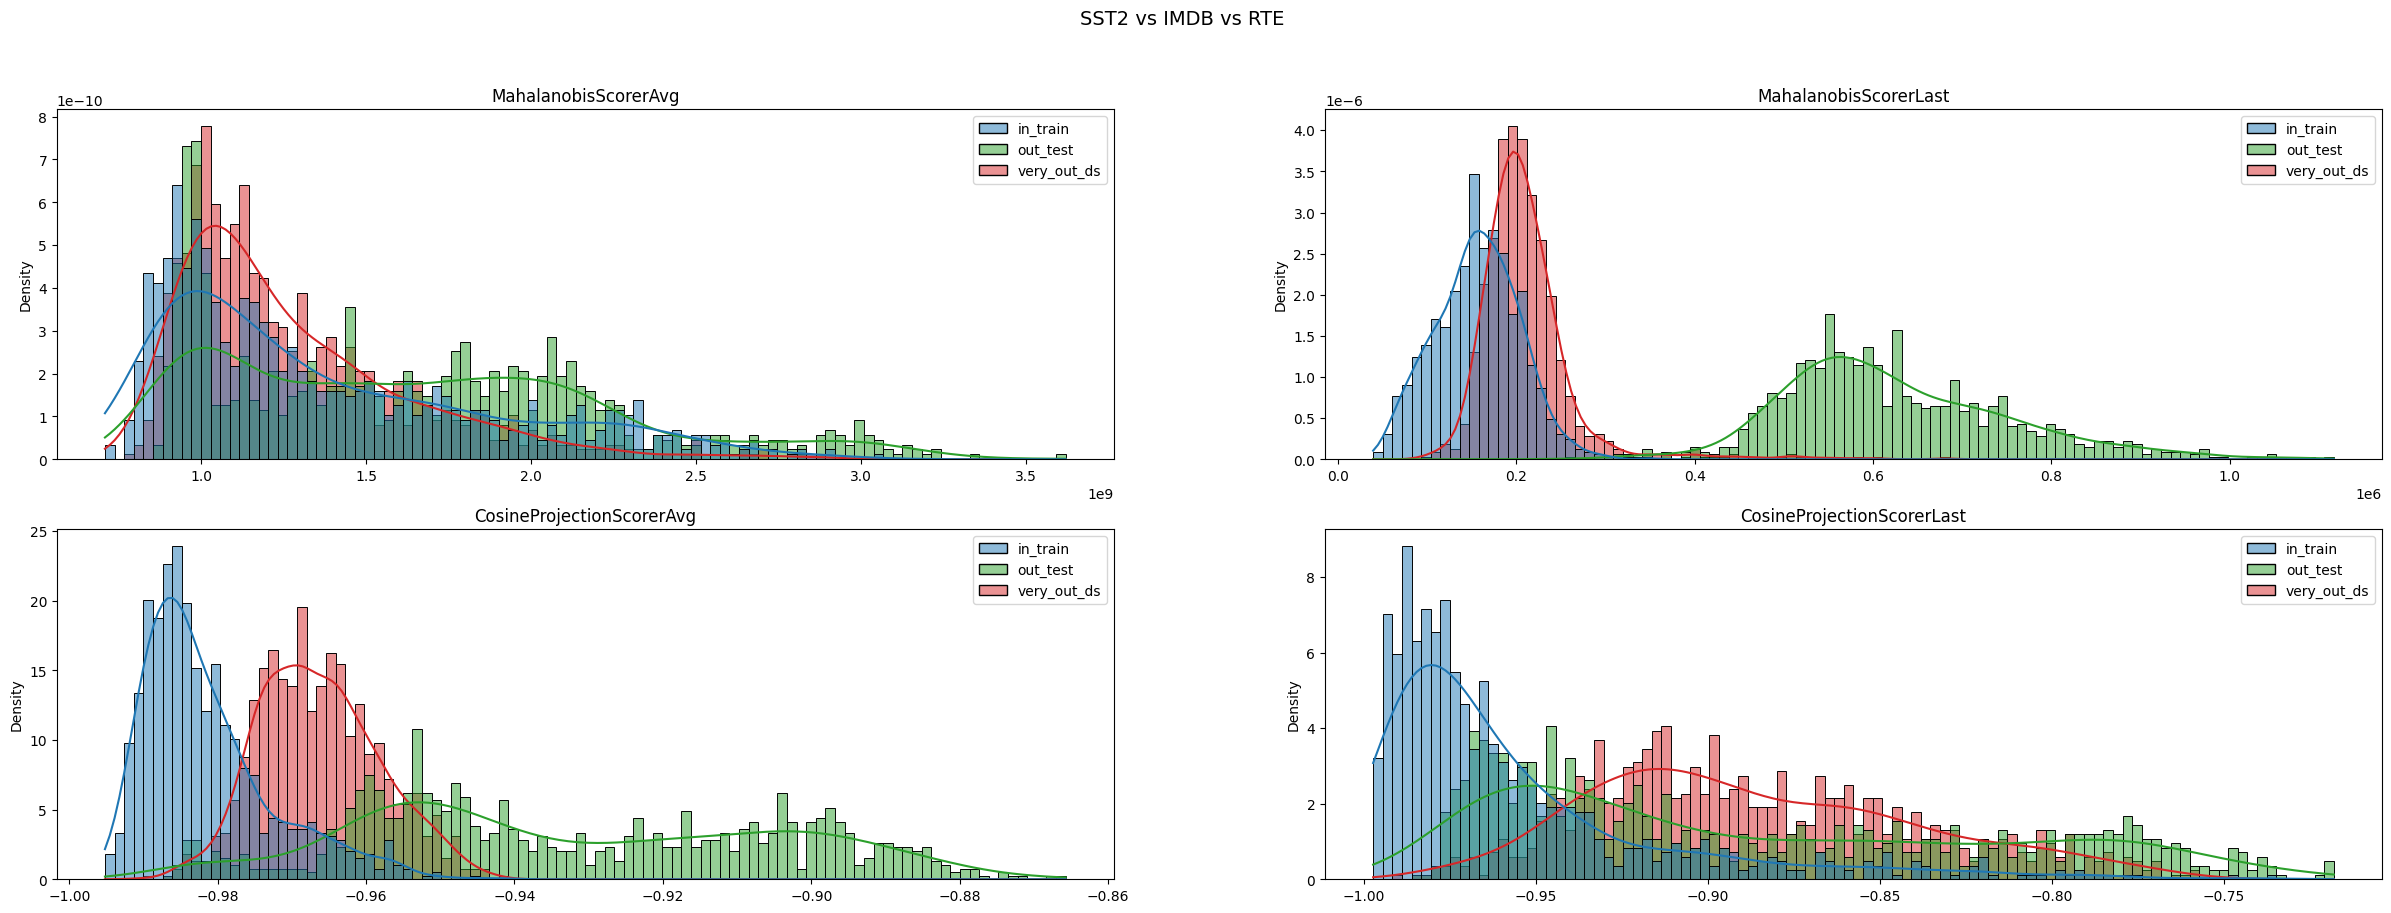

In [83]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(30, 10))
fig.suptitle("SST2 vs IMDB vs RTE", size=14)    

for (scorer, records), ax in zip(all_scores.items(), axes.flatten()):
    plot_scorer_distrib(scorer, records, ds_names=["in_train","out_test","very_out_ds"], ax=ax, density=True); 

### **Metrics** 

In [84]:
ood_scores = {
    scorer: list(chain(*[
        ele for ele in all_scores[scorer].values()
    ]))
    for scorer in scorer_names
}

In [86]:
ood_labels_in = [0 for i in range(1000)]
ood_labels_out = [1 for i in range(1000)]
ood_labels = ood_labels_in + ood_labels_out + ood_labels_out  + ood_labels_out 


roc = {
    scorer: roc_curve(ood_labels, ood_scores[scorer], pos_label=1)
    for scorer in scorer_names
}

In [87]:
roc

{'MahalanobisScorerAvg': (array([0.   , 0.   , 0.   , ..., 0.998, 0.998, 1.   ]),
  array([0.00000000e+00, 3.33333333e-04, 1.70000000e-02, ...,
         9.99666667e-01, 1.00000000e+00, 1.00000000e+00]),
  array([3.62041247e+09, 3.62041246e+09, 3.05035365e+09, ...,
         7.25101288e+08, 7.24221969e+08, 7.07788274e+08])),
 'MahalanobisScorerLast': (array([0.   , 0.   , 0.   , ..., 0.999, 0.999, 1.   ]),
  array([0.00000000e+00, 3.33333333e-04, 3.39000000e-01, ...,
         9.99666667e-01, 1.00000000e+00, 1.00000000e+00]),
  array([1116821.75      , 1116820.75      ,  351368.21875   , ...,
           42277.8046875 ,   41330.98046875,   39283.54296875])),
 'CosineProjectionScorerAvg': (array([0.   , 0.   , 0.   , 0.001, 0.001, 0.002, 0.002, 0.003, 0.003,
         0.004, 0.004, 0.005, 0.005, 0.006, 0.006, 0.007, 0.007, 0.008,
         0.008, 0.009, 0.009, 0.01 , 0.01 , 0.011, 0.011, 0.012, 0.012,
         0.014, 0.014, 0.017, 0.017, 0.018, 0.018, 0.019, 0.019, 0.02 ,
         0.02 , 0.02

In [90]:
ood_scores

{'MahalanobisScorerLast': [175702.8125,
  123701.9296875,
  166845.21875,
  222232.109375,
  141125.109375,
  65078.57421875,
  159588.125,
  80092.34375,
  172021.921875,
  145724.5,
  123991.2265625,
  126401.5546875,
  151132.96875,
  176417.296875,
  133365.46875,
  152732.453125,
  122491.2734375,
  121536.8515625,
  112162.8671875,
  163631.375,
  112188.140625,
  150783.53125,
  165176.34375,
  140490.859375,
  181208.453125,
  167579.5625,
  193352.09375,
  187818.640625,
  105191.3984375,
  184373.40625,
  200025.34375,
  167254.59375,
  122368.3515625,
  161759.375,
  171560.796875,
  69424.1171875,
  121249.640625,
  181709.46875,
  161128.3125,
  190218.9375,
  146031.46875,
  198571.90625,
  84167.65625,
  71741.359375,
  151795.84375,
  139134.96875,
  236210.625,
  225309.109375,
  233978.59375,
  128627.5703125,
  219550.21875,
  137939.625,
  124624.0,
  219547.03125,
  116006.21875,
  228021.203125,
  209976.046875,
  208603.21875,
  149121.1875,
  259182.734375,
  17

In [92]:
ood_labels_in = [
    config_args_sst2["ood_label"] 
    for _ in range(config_args_sst2["train_size"]+1000) 
]

ood_labels_out = [
    config_args_imdb["ood_label"] 
    for _ in range(config_args_imdb["test_size"] + 1000)
]


ood_labels = ood_labels_in + ood_labels_out  


ood_scores = {
    scorer: list(chain(*[
        ds for ds in all_scores[scorer].values()
    ]))
    for scorer in scorer_names
}

roc = {
    scorer: roc_curve(ood_labels, ood_scores[scorer], pos_label=1)
    for scorer in scorer_names
}

prc = {
    scorer: precision_recall_curve(ood_labels, ood_scores[scorer], pos_label=1)
    for scorer in scorer_names
}

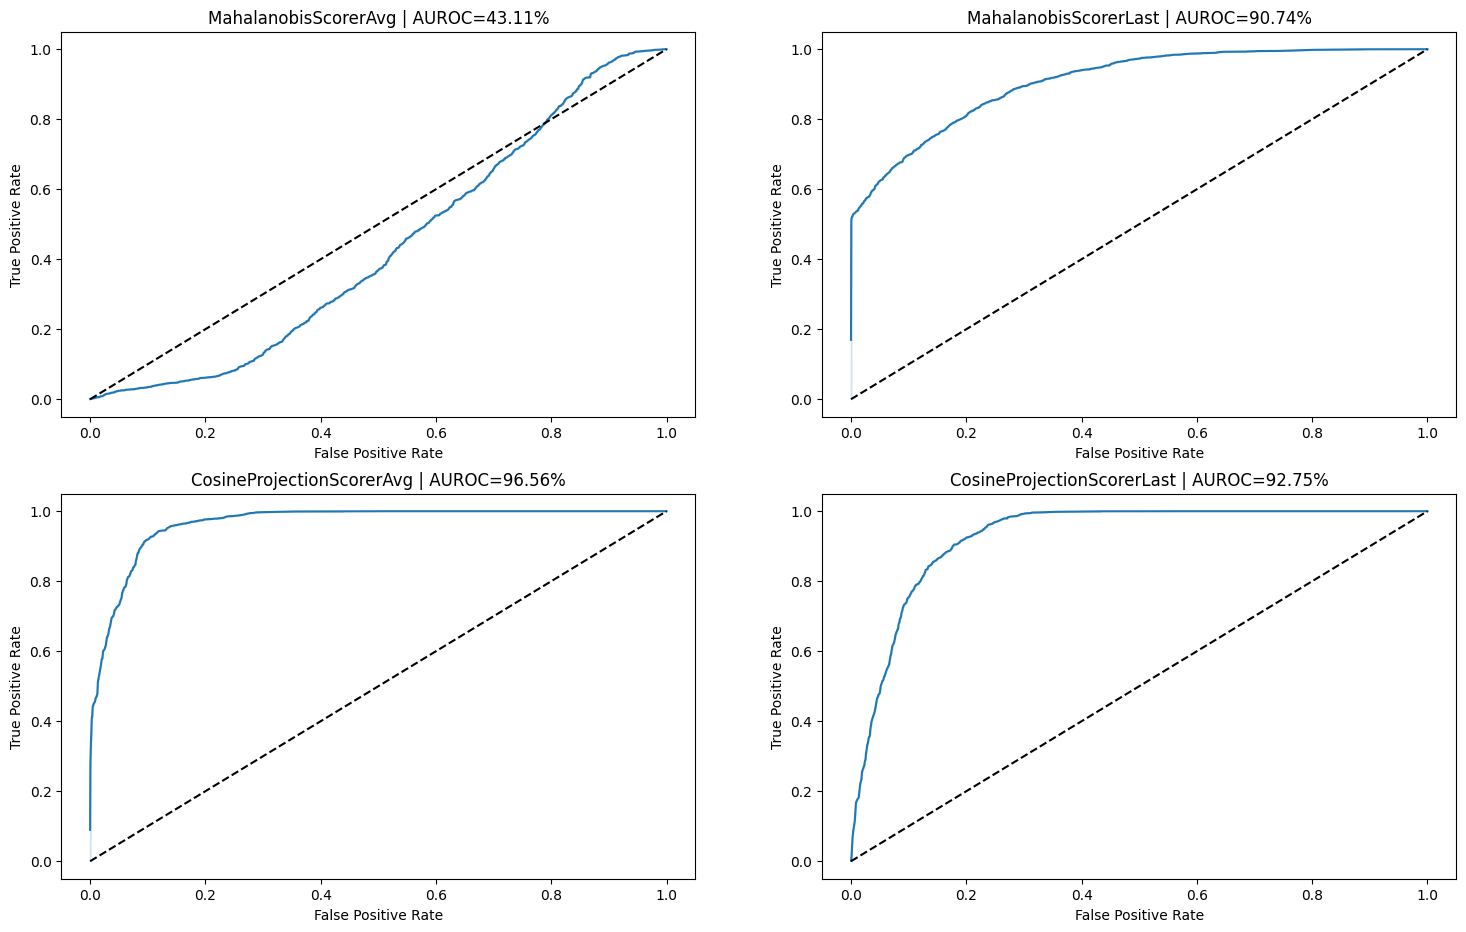

In [94]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 11))

for (scorer, (fpr, tpr, _)), ax in zip(roc.items(), axes.flatten()): 
    sns.lineplot(x=fpr, y=tpr, ax=ax)
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle="dashed", ax=ax, color="black") 

    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")

    auroc = auc(fpr, tpr)
    ax.set_title(f"{scorer} | AUROC={round(100*auroc, 2)}%"); 